# Compile and use geomed3 library on MacOS using HomeBrew GCC
See https://brew.sh to install HomeBrew on your MacOS

In [1]:
# install GCC compiler
!brew install gcc

To reinstall 11.1.0, run:
  brew reinstall gcc


In [2]:
# compile the library with the current GCC version
GCCS=!ls /usr/local/bin/gcc-?? | sort -n
print ("Installed GCC compilers", GCCS)
GCC = GCCS[0]
print ("Used GCC compiler", GCC)
!rm -f libgeomed3dv4.so
!{GCC} -O2 -mmmx -msse -lm -funroll-all-loops -fopenmp -fPIC -D_FILE_OFFSET_BITS=64 -Wall \
    -shared geomed3dv4.c -o libgeomed3dv4.so

Installed GCC compilers ['/usr/local/bin/gcc-11']
Used GCC compiler /usr/local/bin/gcc-11


In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline

## Load binary library

In [4]:
import ctypes
lib = ctypes.cdll.LoadLibrary('libgeomed3dv4.so')

## Load python library

In [5]:
from geomed3dv4 import *

## Define processing parameters

In [6]:
# input raster
DSM = 'DSM.15m.32645.nc'
# Gaussian filtering parameters
GAMMA1 = 3
GAMMA2 = 5
# output model resolution
XRES = YRES = 50
RADIUS = 100
# processing area
xmin, xmax = 340000, 345000
ymin, ymax = 6045000, 6050000

## Load raster

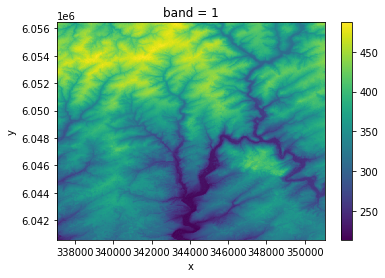

In [7]:
raster0 = xr.open_rasterio(DSM).squeeze()
raster0.plot()

## Raster filtering

In [8]:
raster = raster_gamma_range(raster0, GAMMA1, GAMMA2)

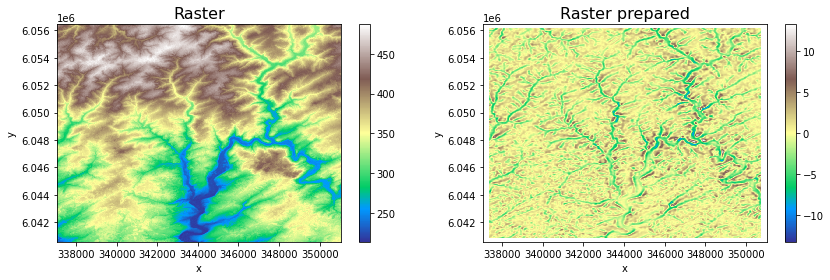

In [9]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14, 4))

raster0.plot(ax=ax1, cmap='terrain')
ax1.set_title('Raster',fontsize=16)

raster.plot(ax=ax2, cmap='terrain')

ax2.set_title('Raster prepared',fontsize=16)

fig.subplots_adjust(hspace=0.2)
plt.show()

## Make grid for area

In [10]:
xs = np.arange(xmin,xmax,XRES)
ys = np.arange(ymin,ymax,YRES)
(xs, ys) = np.meshgrid(xs, ys)

In [11]:
df_grid = pd.DataFrame({'x':xs.ravel(), 'y': ys.ravel(), 'z': 0})
df_grid

,x,y,z
0,340000,6045000,0
1,340050,6045000,0
2,340100,6045000,0
3,340150,6045000,0
4,340200,6045000,0
...,...,...,...
9995,344750,6049950,0
9996,344800,6049950,0
9997,344850,6049950,0
9998,344900,6049950,0


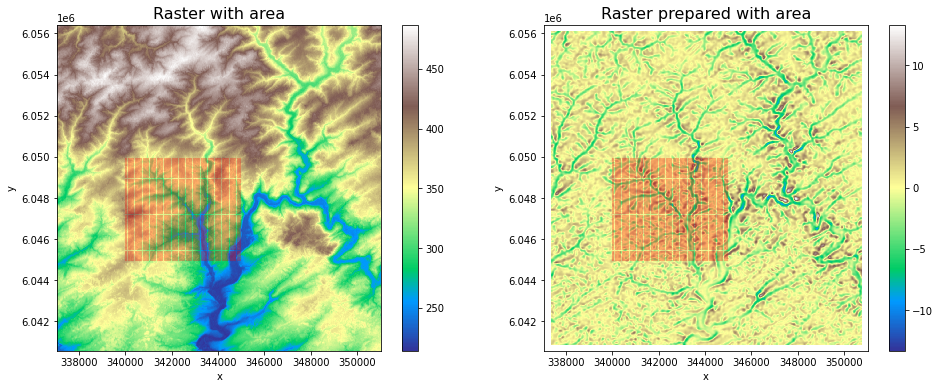

In [12]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))

raster0.plot(cmap='terrain', ax=ax1)
ax1.scatter(df_grid.x,df_grid.y, s=0.01, c='red')
ax1.set_title('Raster with area',fontsize=16)

raster.plot(cmap='terrain', ax=ax2)
ax2.scatter(df_grid.x,df_grid.y, s=0.01, c='red')
ax2.set_title('Raster prepared with area',fontsize=16)

plt.show()

## Calculate 3D volume
'orig' is the input raster repeated by depth coordinate for debug reasons

In [13]:
ds3d = geomed(lib,raster,df_grid,radius_min=0,radius_max=RADIUS,gridded=True)
ds3d

/usr/local/lib/python3.7/site-packages/xarray/core/dataarray.py:746: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


<xarray.Dataset>
Dimensions:     (x: 100, y: 100, z: 101)
Coordinates:
  * y           (y) int64 6045000 6045050 6045100 ... 6049850 6049900 6049950
  * x           (x) int64 340000 340050 340100 340150 ... 344850 344900 344950
    surface     (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * z           (z) float64 -1.06e+03 -1.05e+03 -1.039e+03 ... -21.21 -10.6 0.0
    projection  <U1 ''
Data variables:
    orig        (z, y, x) float32 2.15 1.949 1.347 ... -1.289 -1.695 -2.197
    mean        (z, y, x) float32 0.0904 0.143 0.1952 0.3178 ... nan nan nan nan
Attributes:
    epsg:     0

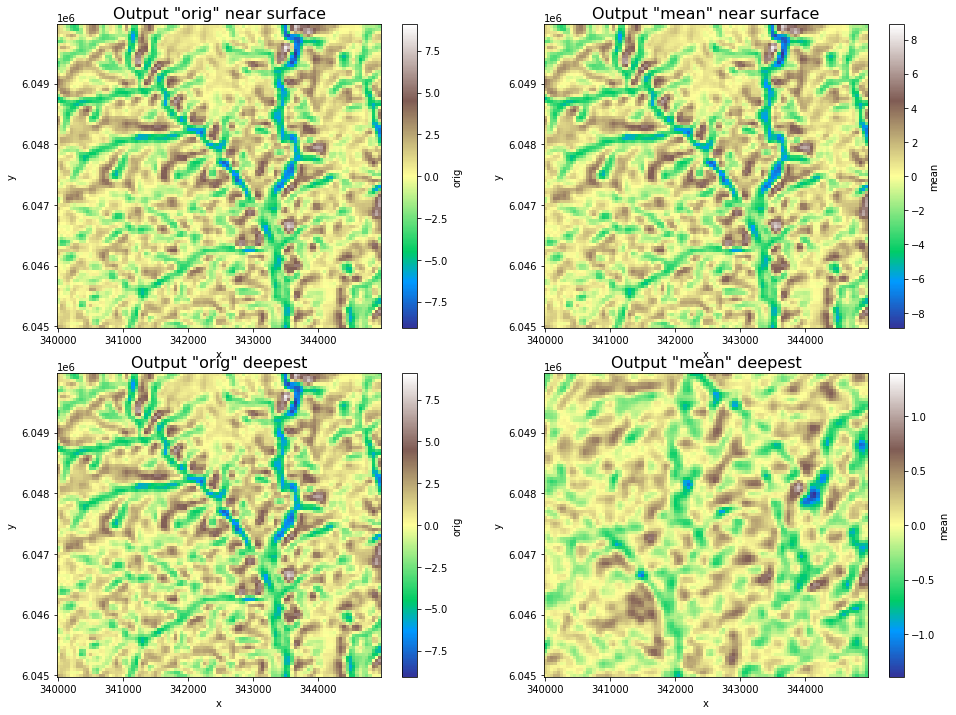

In [14]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(16, 12))

ds3d['orig'].isel(z=-2).plot(cmap='terrain', ax=ax1)
ax1.set_title('Output "orig" near surface',fontsize=16)

ds3d['mean'].isel(z=-2).plot(cmap='terrain', ax=ax2)
ax2.set_title('Output "mean" near surface',fontsize=16)

ds3d['orig'].isel(z=0).plot(cmap='terrain', ax=ax3)
ax3.set_title('Output "orig" deepest',fontsize=16)

ds3d['mean'].isel(z=0).plot(cmap='terrain', ax=ax4)
ax4.set_title('Output "mean" deepest',fontsize=16)

fig.subplots_adjust(hspace=0.15)
plt.show()

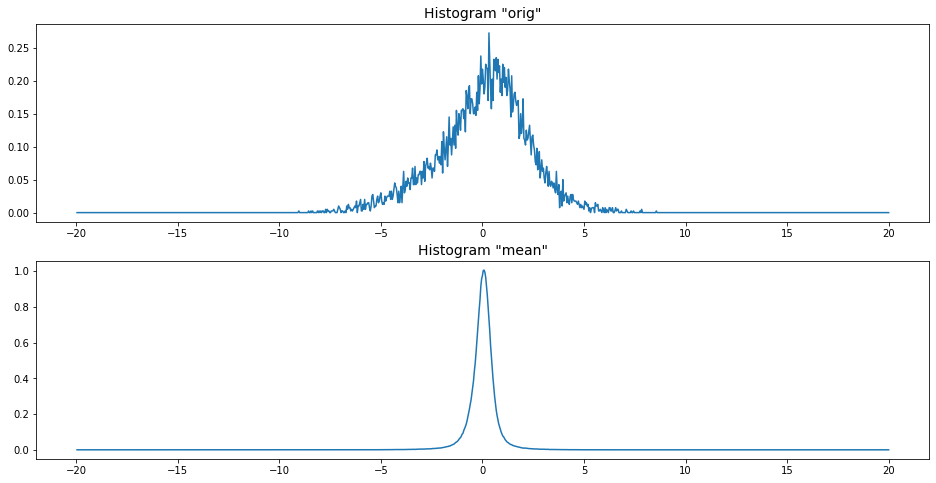

In [15]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16, 8))

hist, bin_edges = np.histogram(ds3d['orig'], bins=1000, density=True,
                              range=(-20,20))
ax1.plot(bin_edges[1:],hist)
ax1.set_title('Histogram "orig"', fontsize=14)

hist, bin_edges = np.histogram(ds3d['mean'], bins=1000, density=True,
                              range=(-20,20))
ax2.plot(bin_edges[1:],hist)
ax2.set_title('Histogram "mean"', fontsize=14)

plt.show()